<a href="https://colab.research.google.com/github/lucasdp5/ds2/blob/main/perea_ds2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import HTML, display
import base64
from io import BytesIO
import datetime

In [2]:
Definimos una función para centralizar la lectura (Buenas prácticas de ingeniería)
def load_github_csv(file_name):
    # Reemplaza con tu base URL de GitHub Raw
    base_url = "https://raw.githubusercontent.com/lucasdp5/ds2/main/"
    full_url = f"{base_url}{file_name}"

    try:
        df = pd.read_csv(full_url)
        print(f"✅ {file_name} cargado exitosamente. Registros: {df.shape[0]}")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {file_name}: {e}")
        return None

# Lectura de las tablas principales
df_reserva = load_github_csv("reserva.csv")
df_vehiculo = load_github_csv("vehiculo.csv")
df_cliente = load_github_csv("cliente.csv")
df_pago = load_github_csv("pago.csv")

✅ reserva.csv cargado exitosamente. Registros: 4036
✅ vehiculo.csv cargado exitosamente. Registros: 51
✅ cliente.csv cargado exitosamente. Registros: 7357
✅ pago.csv cargado exitosamente. Registros: 4060


In [3]:
df_reserva.columns


Index(['id', 'numero', 'sitio_salida', 'sitio_llegada', 'provincia_salida',
       'provincia_llegada', 'vehiculo_idvehiculo', 'fecha_salida',
       'fecha_devolucion', 'fecha_entrada', 'kms_entrada', 'kms_salida',
       'forma_de_pago', 'tarjeta_credito', 'numero_tarjeta',
       'fecha_venc_tarjeta', 'codigo_tarjeta', 'cliente_idcliente',
       'info_adicional', 'tarifa_1', 'km_tarifa_1', 'tarifa_2', 'km_tarifa_2',
       'tarifa_semanal', 'tarifa_mensual', 'cant_dias', 'meses', 'semanas',
       'subtotal', 'iva', 'importe_total', 'combustible_salida',
       'combustible_entrada', 'estado', 'created_by', 'updated_by',
       'created_at', 'updated_at', 'bonificacion', 'tipo', 'comision',
       'nrofactura', 'temporada', 'telcontacto', 'retorno', 'tanque_lleno',
       'franquicia_dano', 'franquicia_robo', 'combustible',
       'reducc_franq_danos_xdia', 'km_excedido', 'cargo_km_sup',
       'cargo_hs_sup', 'reduccion_franq_danos', 'km_origen_destino',
       'danios_devolucion'

In [4]:
#Se procede a eliminar todas aquellas columnas que no aportan valor
cols_reserva_ok = [
    'id', 'vehiculo_idvehiculo', 'cliente_idcliente', 'fecha_salida',
    'fecha_devolucion', 'fecha_entrada','created_at', 'total_dias', 'importe_total',
    'saldo', 'total_pagos', 'estado', 'subtotal',
    'kms_salida', 'kms_entrada', 'danios_devolucion'
]
df_reserva = df_reserva[cols_reserva_ok]

cols_vehiculo_ok = [
    'idvehiculo', 'marca', 'modelo', 'clase', 'kilometros',
    'propiedad', 'precio', 'km_aceite', 'venc_rto'
]
df_vehiculo = df_vehiculo[cols_vehiculo_ok]

cols_cliente_ok = ['idcliente', 'nombre', 'apellido', 'domicilio']
df_cliente = df_cliente[cols_cliente_ok]

cols_pago_ok = ['idpago', 'importe', 'fecha','reserva_id']
df_pago = df_pago[cols_pago_ok]

In [5]:
# 1. Conversión de Timestamps Unix a Datetime
# Si están en segundos, usamos unit='s'. Si están en milisegundos, unit='ms'.
unix_cols = {
    'df_reserva': ['fecha_salida', 'fecha_devolucion', 'fecha_entrada', 'created_at'],
    'df_vehiculo' : ['venc_rto'],
    'df_pago': ['fecha']
}

for col in unix_cols['df_reserva']:
    df_reserva[col] = pd.to_datetime(df_reserva[col], unit='s', errors='coerce')

for col in unix_cols['df_vehiculo']:
    df_vehiculo[col] = pd.to_datetime(df_vehiculo[col], unit='s', errors='coerce')

for col in unix_cols['df_pago']:
    df_pago[col] = pd.to_datetime(df_pago[col], unit='s', errors='coerce')

In [6]:
# Vamos a crear un df_master. Usaremos un left join partiendo de la tabla reserva,
# ya que es el hecho principal de nuestro negocio.

# 1. Unimos Reservas con Vehículos
# Queremos todas las reservas, y la info del vehículo si existe
df_master = pd.merge(
    df_reserva,
    df_vehiculo,
    left_on='vehiculo_idvehiculo',
    right_on='idvehiculo',
    how='left'
)

# 2. Unimos el resultado con Clientes
df_master = pd.merge(
    df_master,
    df_cliente,
    left_on='cliente_idcliente',
    right_on='idcliente',
    how='left'
)

# 3. Si quieres ver el comportamiento de pagos agregados
# Nota: Como una reserva puede tener muchos pagos, lo ideal es agrupar pagos primero
df_pago_agrupado = df_pago.groupby('reserva_id')['importe'].sum().reset_index()
df_pago_agrupado.columns = ['reserva_id', 'total_pagado_acumulado']

df_master = pd.merge(
    df_master,
    df_pago_agrupado,
    left_on='id',
    right_on='reserva_id',
    how='left'
)

print(f"Dataset Maestro creado. Forma final: {df_master.shape}")

Dataset Maestro creado. Forma final: (4036, 31)


In [7]:
df_master.columns

Index(['id', 'vehiculo_idvehiculo', 'cliente_idcliente', 'fecha_salida',
       'fecha_devolucion', 'fecha_entrada', 'created_at', 'total_dias',
       'importe_total', 'saldo', 'total_pagos', 'estado', 'subtotal',
       'kms_salida', 'kms_entrada', 'danios_devolucion', 'idvehiculo', 'marca',
       'modelo', 'clase', 'kilometros', 'propiedad', 'precio', 'km_aceite',
       'venc_rto', 'idcliente', 'nombre', 'apellido', 'domicilio',
       'reserva_id', 'total_pagado_acumulado'],
      dtype='object')

In [8]:
# 1. Definimos las columnas que realmente aportan valor al negocio
# Quitamos los IDs duplicados y nombres/apellidos si no vamos a hacer análisis de texto
cols_finales = [
    'id', 'fecha_salida', 'fecha_devolucion', 'fecha_entrada', 'created_at',
    'total_dias', 'importe_total', 'subtotal', 'saldo', 'total_pagos', 'total_pagado_acumulado',
    'estado', 'marca', 'modelo', 'clase',
    'kms_salida', 'kms_entrada', 'danios_devolucion',
    'kilometros', 'km_aceite', 'venc_rto'
]

df_final = df_master[cols_finales].copy()

# 2. Reemplazamos NaNs en pagos acumulados por 0
# (Si es NaN es porque no hubo registros en la tabla pagos, ergo pagó 0)
df_final['total_pagado_acumulado'] = df_final['total_pagado_acumulado'].fillna(0)

# 3. Pequeño ajuste: Si saldo es nulo pero tenemos importe y pagos, lo calculamos
df_final['saldo'] = df_final['saldo'].fillna(df_final['importe_total'] - df_final['total_pagado_acumulado'])

print(f"Dataset depurado. Columnas actuales: {len(df_final.columns)}")

Dataset depurado. Columnas actuales: 21


In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036 entries, 0 to 4035
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      4036 non-null   int64         
 1   fecha_salida            4002 non-null   datetime64[ns]
 2   fecha_devolucion        4003 non-null   datetime64[ns]
 3   fecha_entrada           175 non-null    datetime64[ns]
 4   created_at              4036 non-null   datetime64[ns]
 5   total_dias              3900 non-null   float64       
 6   importe_total           4029 non-null   float64       
 7   subtotal                4035 non-null   float64       
 8   saldo                   4029 non-null   float64       
 9   total_pagos             3370 non-null   float64       
 10  total_pagado_acumulado  4036 non-null   float64       
 11  estado                  4036 non-null   int64         
 12  marca                   4036 non-null   object  

In [10]:
# Diccionarios de mapeo
dict_estados = {
    0: 'Reserva', 1: 'Alquilado', 2: 'Entregado', 3: 'Cancelado',
    4: 'Cerrado', 5: 'Cerrado Pendiente', 6: 'Controlado'
}

dict_clases = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N'
}

# Aplicamos el mapeo creando nuevas columnas
df_final['estado_desc'] = df_final['estado'].map(dict_estados)
df_final['clase_desc'] = df_final['clase'].map(dict_clases)

In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036 entries, 0 to 4035
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      4036 non-null   int64         
 1   fecha_salida            4002 non-null   datetime64[ns]
 2   fecha_devolucion        4003 non-null   datetime64[ns]
 3   fecha_entrada           175 non-null    datetime64[ns]
 4   created_at              4036 non-null   datetime64[ns]
 5   total_dias              3900 non-null   float64       
 6   importe_total           4029 non-null   float64       
 7   subtotal                4035 non-null   float64       
 8   saldo                   4029 non-null   float64       
 9   total_pagos             3370 non-null   float64       
 10  total_pagado_acumulado  4036 non-null   float64       
 11  estado                  4036 non-null   int64         
 12  marca                   4036 non-null   object  

In [12]:
# Se observa 136 valores nulos en total_dias. Se recalculan teniendo la fecha de salida y devolucion.
# Además, se eliminan registros imposibles de analizar porque falta información clave.

# 1. Recalcular total_dias donde sea nulo
# Usamos .dt.days para obtener la diferencia entera
df_final['total_dias'] = df_final['total_dias'].fillna(
    (df_final['fecha_devolucion'] - df_final['fecha_salida']).dt.days
)

# 2. Eliminar inconsistencias temporales (Salida > Devolución)
# Solo mantenemos donde la salida es antes o igual a la devolución
df_final = df_final[df_final['fecha_salida'] <= df_final['fecha_devolucion']]

# 3. Eliminar los 34 registros sin fecha_salida (son huérfanos)
df_final = df_final.dropna(subset=['fecha_salida'])


In [14]:
# Consistencia de Kilometrajes
# Un auto no puede volver con menos kilómetros de los que salió. Esto arruinaría tu análisis de desgaste de flota.

# 1. Identificar y limpiar inconsistencias de KM
mask_km_error = df_final['kms_entrada'] < df_final['kms_salida']
# Opción Senior: En lugar de borrar, si el error es pequeño podemos poner NaN para no sesgar
df_final.loc[mask_km_error, 'kms_entrada'] = pd.NA

# 2. Calcular KM recorridos (Feature Engineering preventivo)
df_final['km_recorridos_alquiler'] = df_final['kms_entrada'] - df_final['kms_salida']

In [16]:
# Saneamiento Financiero (total_pagos vs acumulado)
# Como notamos anteriormente, total_pagos tiene muchos nulos, pero total_pagado_acumulado (que calculamos desde la tabla de pagos) es más confiable porque proviene de pagos

# Eliminamos la columna redundante y con nulos
df_final = df_final.drop(columns=['total_pagos'])

# Si el saldo es nulo, lo calculamos como la deuda pendiente real
df_final['saldo'] = df_final['saldo'].fillna(df_final['importe_total'] - df_final['total_pagado_acumulado'])

# Un saldo negativo significa saldo a favor del cliente.
# Para el análisis de mora, nos interesan solo los saldos > 0.


df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4002 entries, 0 to 4035
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      4002 non-null   int64         
 1   fecha_salida            4002 non-null   datetime64[ns]
 2   fecha_devolucion        4002 non-null   datetime64[ns]
 3   fecha_entrada           175 non-null    datetime64[ns]
 4   created_at              4002 non-null   datetime64[ns]
 5   total_dias              4002 non-null   float64       
 6   importe_total           3995 non-null   float64       
 7   subtotal                4002 non-null   float64       
 8   saldo                   3995 non-null   float64       
 9   total_pagado_acumulado  4002 non-null   float64       
 10  estado                  4002 non-null   int64         
 11  marca                   4002 non-null   object        
 12  modelo                  4002 non-null   object       

In [18]:
# Valores duplicados
df_final.duplicated().sum()

np.int64(0)

Se observa que no hay valores duplicados, por lo tanto no se toma ninguna acción en relación a esto.

Se observa que fecha_entrada posee una gran cantidad de nulos. Este campo indica cuando realmente se hizo la devolución de un vehiculo. La fecha_devolucion es la fecha pactada, pero si el cliente solicita una extension de los días, entonces se identifica con fecha_entrada. Se procede a eliminar del DF porque no aporta información.

In [20]:
# Eliminamos la columna redundante y con nulos
df_final = df_final.drop(columns=['fecha_entrada'])

Perfil de Ingresos por Clase de Vehículo

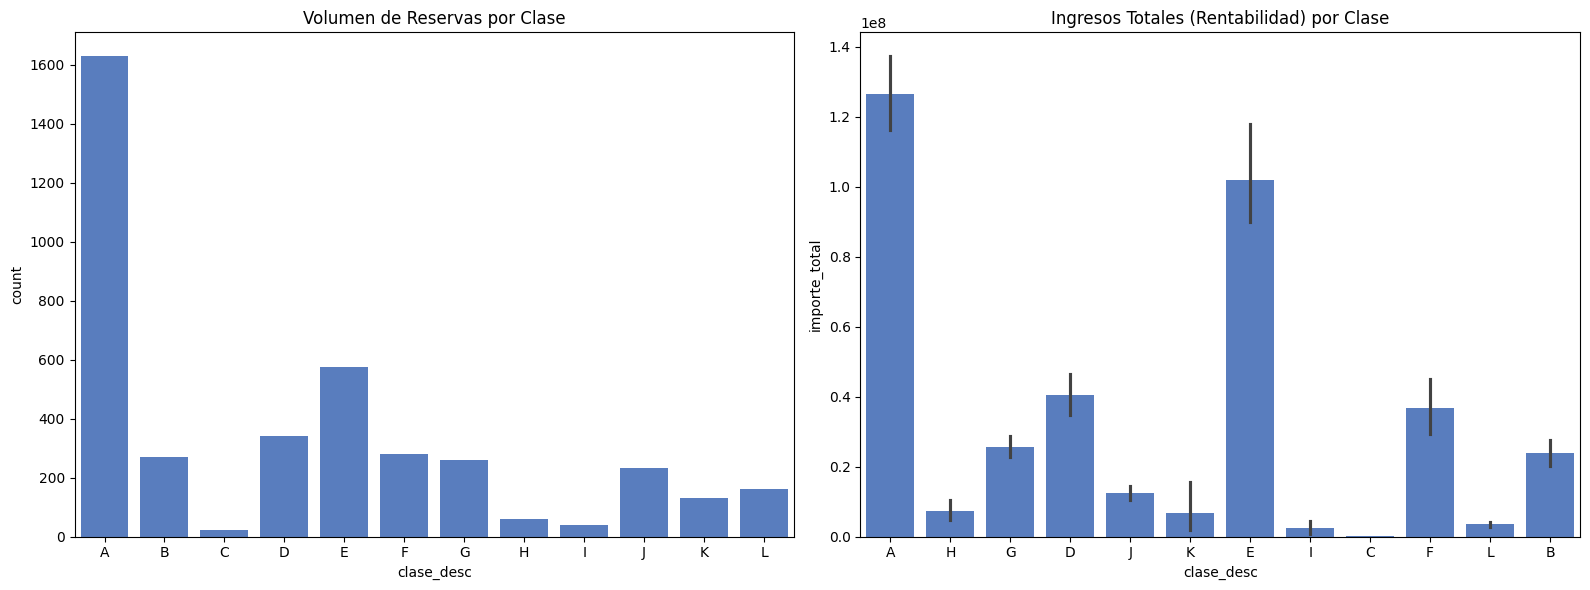

In [22]:
# Queremos saber qué categoría de vehículo es el "caballito de batalla" del negocio.

# Configuramos estilo profesional
plt.style.use('seaborn-v0_8-muted')
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico A: Volumen de Alquileres por Clase
sns.countplot(data=df_final, x='clase_desc', order=sorted(df_final['clase_desc'].unique()), ax=ax[0])
ax[0].set_title('Volumen de Reservas por Clase')

# Gráfico B: Ingreso Total Acumulado por Clase
sns.barplot(data=df_final, x='clase_desc', y='importe_total', estimator=sum, ax=ax[1])
ax[1].set_title('Ingresos Totales (Rentabilidad) por Clase')

plt.tight_layout()
plt.show()

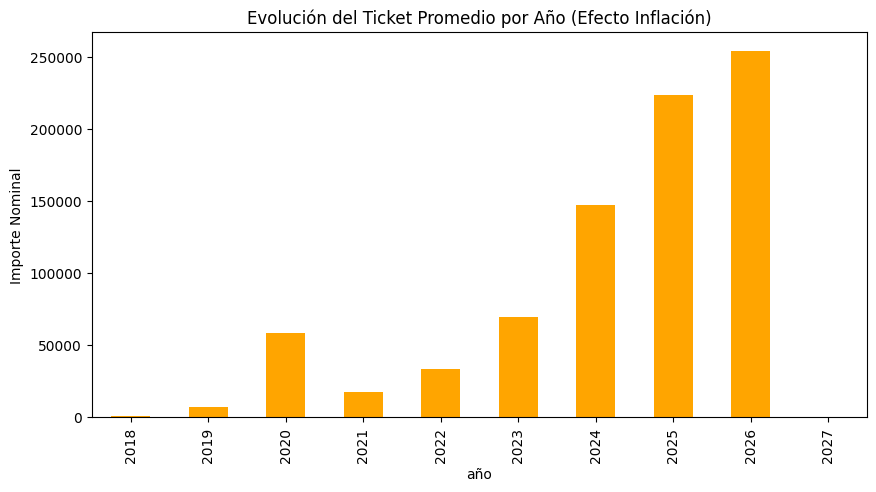

In [28]:
# Analizar la evolución del ticket promedio por año
df_final['año'] = df_final['fecha_salida'].dt.year
ticket_promedio = df_final.groupby('año')['importe_total'].mean()

plt.figure(figsize=(10, 5))
ticket_promedio.plot(kind='bar', color='orange')
plt.title('Evolución del Ticket Promedio por Año (Efecto Inflación)')
plt.ylabel('Importe Nominal')
plt.show()

Al observar el gráfico de Evolución del Ticket Promedio, la hipótesis de la inflación queda confirmada visualmente: mientras que en 2018 el ticket era casi imperceptible en la escala, para 2026 ha escalado a más de $250.000. Esta subida exponencial es la que genera que las barras de error en tu gráfico de ingresos sean tan grandes.

# Análisis de Morosidad (El "Pain Point" del negocio)
¿Quiénes son los clientes que dejan saldos pendientes? ¿Hay alguna relación con la clase de vehículo o el tipo de cliente?

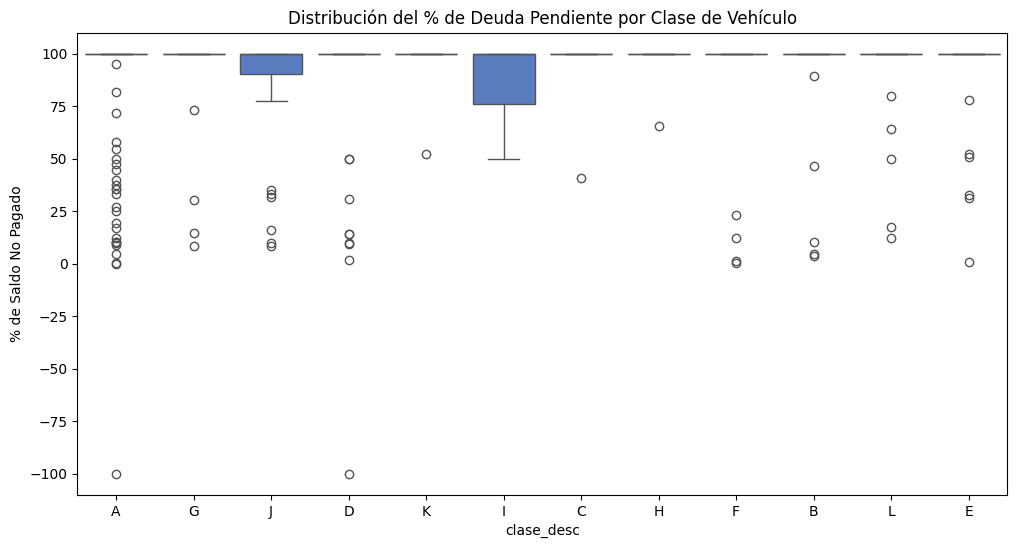

In [23]:
# Creamos una métrica de % de Deuda sobre el Total
df_final['ratio_deuda'] = (df_final['saldo'] / df_final['importe_total']) * 100

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final[df_final['saldo'] > 0], x='clase_desc', y='ratio_deuda')
plt.title('Distribución del % de Deuda Pendiente por Clase de Vehículo')
plt.ylabel('% de Saldo No Pagado')
plt.show()

# Estacionalidad y Demanda (Time Series)

Esto es vital para la logística: ¿En qué meses debemos tener la flota al 100%?

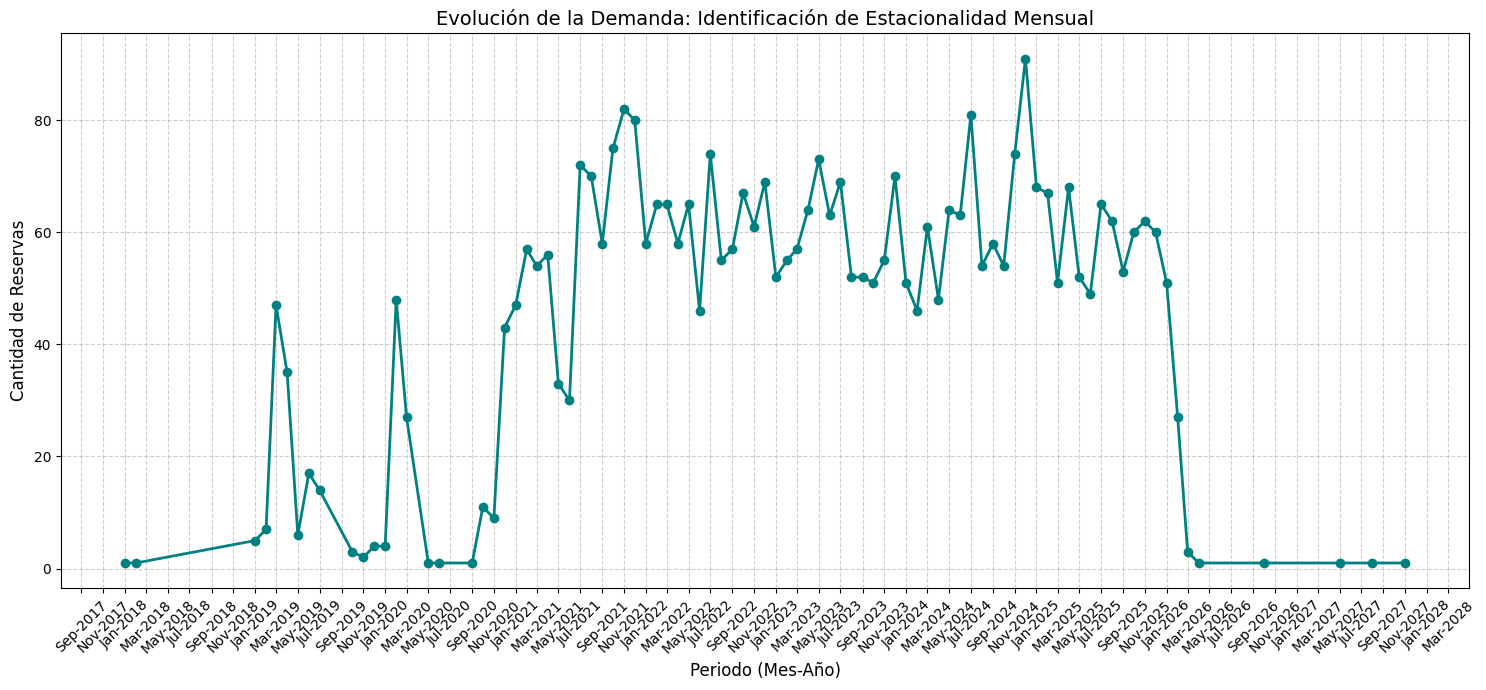

In [27]:
# 1. Agrupamos los datos por mes y año
df_final['mes_año_dt'] = df_final['fecha_salida'].dt.to_period('M').dt.to_timestamp()
demanda_mensual = df_final.groupby('mes_año_dt').size().reset_index(name='cantidad')

# 2. Configuración del gráfico
plt.figure(figsize=(15, 7))
plt.plot(demanda_mensual['mes_año_dt'], demanda_mensual['cantidad'],
         marker='o', linestyle='-', color='#008080', linewidth=2, markersize=6)

# 3. Formateo del Eje X para mostrar Meses (Estacionalidad)
ax = plt.gca()
# Configuramos para que muestre etiquetas cada 2 meses
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# Formato: Nombre del Mes abreviado + Año (ej: Jan-2024)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=45)
plt.title('Evolución de la Demanda: Identificación de Estacionalidad Mensual', fontsize=14)
plt.xlabel('Periodo (Mes-Año)', fontsize=12)
plt.ylabel('Cantidad de Reservas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Debido al contexto de alta inflación del periodo analizado, se implementó un proceso de normalización monetaria mediante la integración de la API de Yahoo Finance. Se deflactaron los ingresos nominales convirtiéndolos a USD mediante el tipo de cambio histórico diario (ARS=X), permitiendo una comparación justa de la rentabilidad entre categorías a lo largo de los años.

In [30]:
import yfinance as yf

# 1. Descargamos el histórico del tipo de cambio (Oficial)
# El ticker para USD a Pesos Argentinos es 'ARS=X'
ticker = "ARS=X"
data = yf.download(ticker, start="2018-01-01", end="2026-02-13")

# Reseteamos el índice para tener la fecha como columna
usd_historico = data['Close'].reset_index()
usd_historico.columns = ['fecha', 'tipo_cambio']
usd_historico['fecha'] = pd.to_datetime(usd_historico['fecha']).dt.date

/tmp/ipython-input-3276863280.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2026-02-13")
[*********************100%***********************]  1 of 1 completed


In [33]:
# Aseguramos que las fechas en tu DF sean solo fecha (sin hora)
df_final['fecha_solo_dia'] = df_final['fecha_salida'].dt.date

# Creamos un diccionario para mapeo rápido {fecha: tipo_cambio}
dict_tc = dict(zip(usd_historico['fecha'], usd_historico['tipo_cambio']))

# Aplicamos el tipo de cambio.
# Si una fecha no existe (fin de semana), usamos ffill (forward fill) o el valor más cercano.
df_final['tipo_cambio_dia'] = df_final['fecha_solo_dia'].map(dict_tc).fillna(method='ffill')

# Calculamos el importe en USD
df_final['importe_usd'] = df_final['importe_total'] / df_final['tipo_cambio_dia']

/tmp/ipython-input-2240204377.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final['tipo_cambio_dia'] = df_final['fecha_solo_dia'].map(dict_tc).fillna(method='ffill')


/tmp/ipython-input-202943724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='clase_desc', y='importe_usd',


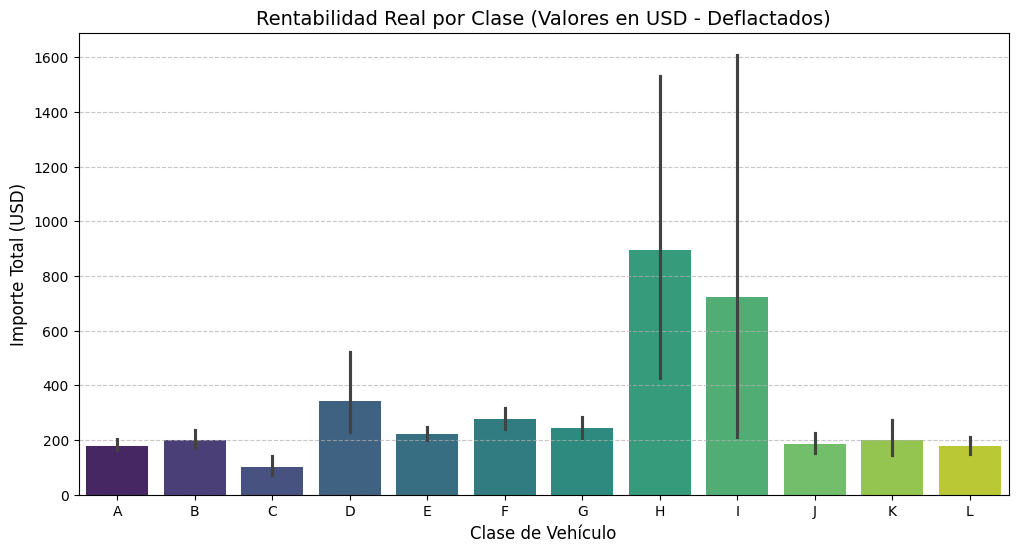

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_final, x='clase_desc', y='importe_usd',
            order=sorted(df_final['clase_desc'].unique()), palette='viridis')

plt.title('Rentabilidad Real por Clase (Valores en USD - Deflactados)', fontsize=14)
plt.ylabel('Importe Total (USD)', fontsize=12)
plt.xlabel('Clase de Vehículo', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()